In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

import sys
sys.path.append("../")

import mitsuba as mi
import drjit as dr
from matplotlib import pyplot as plt
import numpy as np
import skimage as ski
from helpers.polarization_helpers import *
from helpers.render_helpers import *
from helpers.hair_color_helpers import *

print(mi.variants())
mi.set_variant("cuda_ad_spectral_polarized")
dr.set_flag(dr.JitFlag.Debug, True)

['scalar_rgb', 'scalar_spectral', 'scalar_spectral_polarized', 'llvm_ad_rgb', 'llvm_ad_mono', 'llvm_ad_mono_polarized', 'llvm_ad_spectral', 'llvm_ad_spectral_polarized', 'cuda_ad_rgb', 'cuda_ad_mono', 'cuda_ad_mono_polarized', 'cuda_ad_spectral', 'cuda_ad_spectral_polarized']


In [ ]:
scene = mi.load_file("../../scenes/marcus_light_sphere_hair.xml", res=256)

In [6]:
result = render_from_angle(scene, 75, 0.1 * np.pi, 0, spp=128)
img_0 = result[0]
img_90 = result[1]

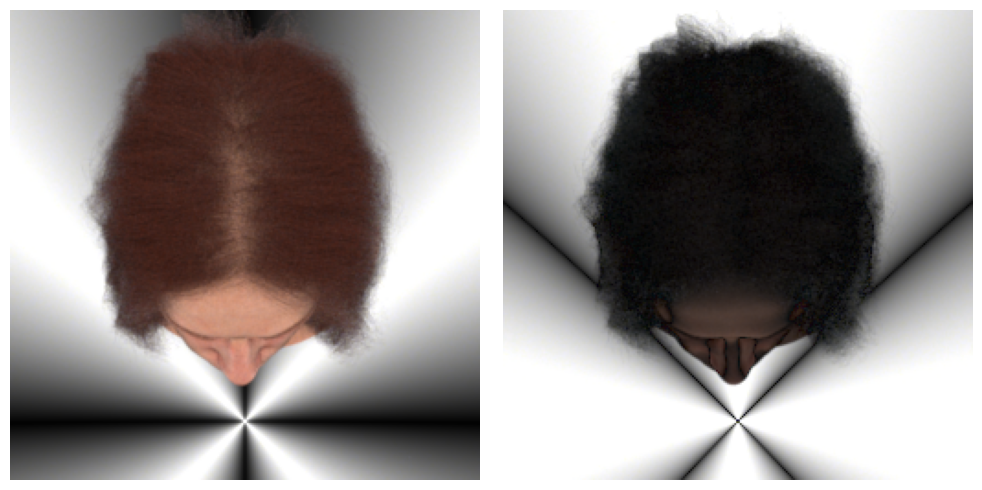

In [7]:
indirect, direct = separate(img_0, img_90)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(np.clip(indirect.squeeze(), 0, 1) ** (1.0 / 2.2))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(np.clip(direct.squeeze(), 0, 1) ** (1.0 / 2.2))

plt.tight_layout()
plt.show()

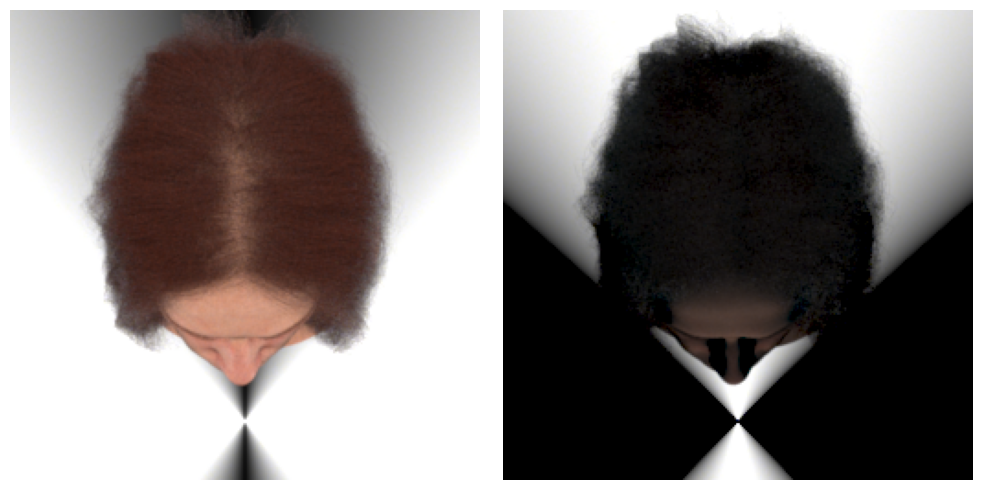

In [8]:
indirect, direct = separate_2(img_0, img_90)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(np.clip(indirect.squeeze(), 0, 1) ** (1.0 / 2.2))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(np.clip(direct.squeeze(), 0, 1) ** (1.0 / 2.2))

plt.tight_layout()
plt.show()

Rendering:  50%|█████     | 2/4 [00:37<00:37, 18.97s/it]drjit.gather(): out-of-bounds read from position 4600000 in an array of size 4600000. (util.py:357)
drjit.gather(): out-of-bounds read from position 4600000 in an array of size 4600000. (util.py:357)
Rendering:  75%|███████▌  | 3/4 [00:59<00:20, 20.32s/it]drjit.gather(): out-of-bounds read from position 4600000 in an array of size 4600000. (util.py:357)
drjit.gather(): out-of-bounds read from position 4600000 in an array of size 4600000. (util.py:357)
Rendering: 100%|██████████| 4/4 [01:19<00:00, 19.95s/it]


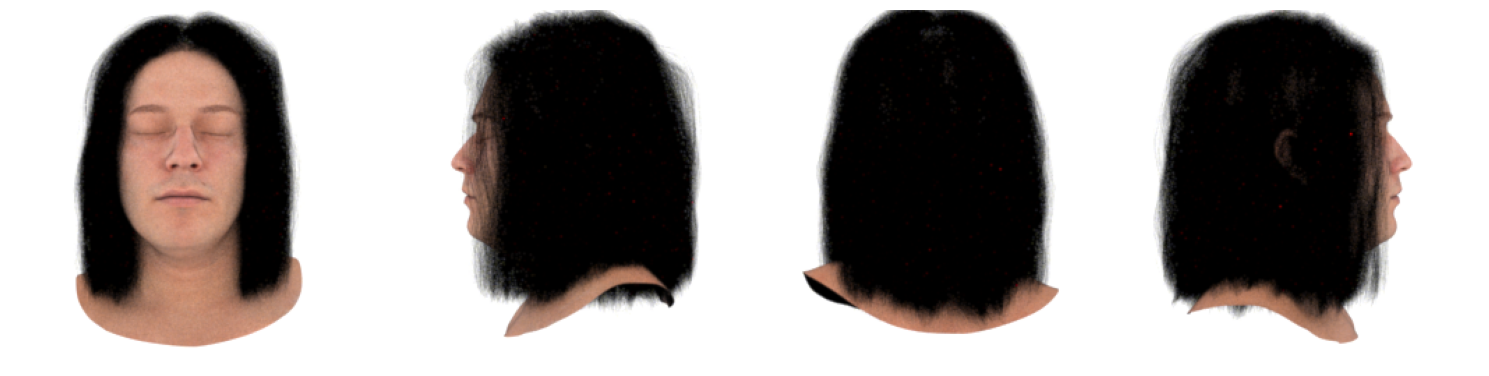

In [6]:
dr.set_flag(dr.JitFlag.Debug, True)

scene = mi.load_file("../../scenes/marcus_light_sphere_hair.xml", res=256, polarizing=False)

params = mi.traverse(scene)
params["polarizer_cam.to_world"] = mi.Transform4f().translate([10000, 10000, 10000])
params.update()

thetas = np.array([0.5*np.pi]*4)
phis = np.linspace(0, 2 * np.pi, 4, endpoint=False)
radius = 75

imgs = render_from_angles(scene, radius, thetas, phis, polarized=False, spp=128)

plt.figure(figsize=(15,4))

for i, img in enumerate(imgs):
	plt.subplot(1, 4, i+1)
	plt.axis("off")
	plt.imshow(np.clip(img.squeeze(), 0, 1) ** (1.0 / 2.2))

plt.tight_layout()
plt.show()

In [23]:
params = mi.traverse(scene)
print(params)
# print(params["hair.bsdf.sigma_a.value"])

SceneParameters[
  -------------------------------------------------------------------------------------------------------
  Name                                                Flags    Type              Parent
  -------------------------------------------------------------------------------------------------------
  sensor.near_clip                                             float             PerspectiveCamera
  sensor.far_clip                                              float             PerspectiveCamera
  sensor.shutter_open                                          float             PerspectiveCamera
  sensor.shutter_open_time                                     float             PerspectiveCamera
  sensor.film.size                                             ScalarVector2u    HDRFilm
  sensor.film.crop_size                                        ScalarVector2u    HDRFilm
  sensor.film.crop_offset                                      ScalarPoint2u     HDRFilm
  sensor.x_fov      

_Kopf Dimensionen unskaliert:_

- x: -15,29; 15,29
- y: 0; 37,23
- z: -14,01; 14,01

Kopf macht ca. 2/3 der Höhe des Modells aus -> Höhe des Kopfes ungefähr 24 Einheiten

In [13]:
# Calculate Head Bounding Box
scene = mi.load_file("../scenes/marcus_light_sphere_hair.xml")
params = mi.traverse(scene)

positions = np.array(params["head.vertex_positions"]).reshape(-1, 3)
min_pos = positions.min(axis=0)
max_pos = positions.max(axis=0)

print(min_pos)
print(max_pos)

[-15.291506 -18.613869 -14.00991 ]
[15.288444 18.613873 14.014215]


_Haare Dimensionen unskaliert:_

- x: -30.90; 32.50
- y: -22.71; 63.58
- z: -33.90; 24.07

In [25]:
scene = mi.load_file("../scenes/marcus_light_sphere_hair.xml")
params = mi.traverse(scene)

positions = np.array(params["hair.control_points"]).reshape(-1, 4)
min_pos = positions.min(0)
max_pos = positions.max(0)

print(min_pos)
print(max_pos)

[-3.0898701e+01 -2.2708553e+01 -3.3900890e+01  9.7500003e-04]
[3.2495605e+01 6.3677959e+01 2.4073988e+01 9.7500003e-04]


_Haarfarbe:_

$$\sigma_a = (\ln(C) / (5.969 - 0.215 \beta_N + 2.532 \beta_N^2 - 10.73 \beta_N^3 + 5.574 \beta_N^4 + 0.245 \beta_N^5))^2$$

mit C = Farbe, $\beta_N$ = azimuthal roughness

Außerdem:

$$\sigma_s = \text{albedo} \cdot \sigma_t, \sigma_a = \sigma_t - \sigma_s$$

Also:

\begin{align*}
\sigma_a &= \sigma_t - \text{albedo} \cdot \sigma_t \\
\sigma_a &= \sigma_t \cdot (1 - \text{albedo}) \\
\frac{\sigma_a}{1 - \text{albedo}} &= \sigma_t
\end{align*}

In [16]:
def calculate_extinction(color, scattering_albedo, beta=0.3):
	extinction = absorption_to_extinction(color_to_absorption(color, beta), scattering_albedo)
	print("Extinction:", ", ".join([str(i) for i in extinction]))


# straight Hair
print("straight Hair")
color = np.array([1.0, 0.925, 0.569])
albedo = 0.8
print(color, albedo)
absorption = color_to_absorption(color)
print(absorption)
extinction = absorption_to_extinction(absorption, albedo)
print(extinction)

# wWavy Hair
print("wWavy Hair")
color = np.array([0.4862745404243469, 0.43137258291244507, 0.3529411852359772])
albedo = 0.3
print(color, albedo)
absorption = color_to_absorption(color)
print(absorption)
extinction = absorption_to_extinction(absorption, albedo)
print(extinction)

# print(absorption_to_extinction(np.array([0, -0.013068, 1.86201]), 0.5))

# Using melanin
print()
print("Using melanin")
radius = 0.003
absorption = melanin_to_absorption(0.11, 0.71)
print("Absorption", absorption)
extinction = absorption_to_extinction(absorption, 0.75)
print("Extinction", extinction / extinction.max())

straight Hair
[1.    0.925 0.569] 0.8
[0.         0.00017529 0.00916999]
[0.         0.00087646 0.0458497 ]
wWavy Hair
[0.48627454 0.43137258 0.35294119] 0.3
[0.01499174 0.02038784 0.03128119]
[0.02141674 0.02912544 0.04468735]

Using melanin
Absorption [0.17886 0.36067 0.8962 ]
Extinction [0.19957599 0.40244365 1.        ]


In [83]:
# extinction in cm^-1 * (mg/ml)^-1
# concentration in mg/ml
def extinction_eumelanin(wavelengths, concentration):
	nm = np.array([209.99, 212.21, 218.91, 223.36, 230.06, 239.00, 245.70, 261.38, 279.30, 294.99, 312.92, 324.13, 342.06, 357.75, 382.42, 407.07, 431.74, 458.67, 483.36, 523.76, 550.70, 588.87, 615.82, 642.77, 680.96, 712.41, 734.88, 764.09, 782.06, 804.53, 820.26])
	ext = np.array([41.900, 40.667, 39.082, 37.145, 35.383, 33.445, 31.507, 29.392, 27.277, 25.338, 23.575, 22.517, 20.578, 18.639, 16.523, 13.878, 11.938, 10.173, 8.9370, 6.9950, 5.7580, 4.5200, 3.9880, 3.2800, 2.7460, 2.2140, 2.0340, 1.8540, 1.6750, 1.4960, 1.4940])
	return np.interp(wavelengths, nm, ext) * concentration

def extinction_pheomelanin(wavelengths, concentration):
	nm = np.array([213.54, 217.92, 222.25, 226.55, 228.59, 232.91, 234.95, 241.54, 243.61, 247.96, 250.18, 256.82, 263.41, 270.05, 276.71, 285.60, 292.24, 298.88, 303.26, 312.08, 323.18, 334.25, 343.05, 351.88, 360.76, 376.38, 387.50, 403.20, 418.85, 430.04, 443.45, 459.17, 481.61, 501.83, 524.32, 549.09, 591.91, 600.98, 625.84, 652.98, 675.59, 700.47, 720.81, 750.22, 770.62, 786.44, 802.28, 820.37, 829.42])
	ext = np.array([47.193, 46.140, 44.738, 43.161, 41.586, 40.183, 38.608, 37.204, 35.803, 34.576, 34.224, 33.170, 31.765, 30.711, 29.831, 28.599, 27.545, 26.490, 25.437, 23.856, 22.273, 20.516, 18.760, 17.179, 15.947, 14.361, 12.952, 11.890, 10.478, 9.5940, 8.3590, 7.4720, 6.0540, 4.9880, 3.9190, 3.0240, 1.5890, 1.7560, 1.3850, 1.1870, 0.9930, 0.7970, 0.6050, 0.4050, 0.5620, 0.3740, 0.3610, 0.1700, 0.1630])
	return np.interp(wavelengths, nm, ext) * concentration

radius = 0.003
c_e = 0.015
c_p = 0.01
wavelengths = np.array([250, 350, 450, 550, 650, 750])
extinction = (extinction_eumelanin(wavelengths, c_e) + extinction_pheomelanin(wavelengths, c_p)) * 2 * radius
print(extinction)
print(", ".join([str(i) for i in extinction]))

[0.00483858 0.00281465 0.00144608 0.00070072 0.00035863 0.00019906]
0.00483858185845284, 0.002814645067852727, 0.0014460760880059414, 0.0007007229858869523, 0.00035862588166100424, 0.0001990641440233761


**Für hellbraunes Haar (in hair bsdf):**

Melaninkonzentrationen:
- Eumelanin: 0.11 mg/mL
- Pheomelanin: 0.71 mg/mL

Absorption berechnet mit Absorptionskoeffizienten von Mitsuba/[d'Eon et al.](https://eugenedeon.com/pdfs/egsrhair.pdf) <br>
Resultierende Absorption (RGB):
- $\{ 0.17886, 0.36067, 0.8962 \}$